# Inputs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Preproccess

## read data

In [2]:
from utils.class_patient import Patients


patients = Patients.loadPatients()
len(patients)

1213

## remove missing

In [3]:
# fill measures whose null represent false value

from constants import NULLABLE_MEASURES


nullableMeasures = NULLABLE_MEASURES

for measureName in nullableMeasures:
    patients.fillMissingMeasureValue(measureName, 0)

In [4]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


In [5]:
# remove patients with less than 80% of data

patients.removePatientByMissingFeatures()
len(patients)

1206

In [6]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [7]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


## split patients

In [8]:
splitedPatients = patients.split(splitPartCount, splitSeed)

len(splitedPatients[0])

225

In [9]:
splitedPatients = patients.split(splitPartCount, splitSeed)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

In [10]:
for trainPatients, testPatients in trainTest():
    print(len(trainPatients.patientList), len(testPatients.patientList))

899 225
899 225
899 225
899 225
900 224


# Transformer

### Transformer

### Using transformer

In [11]:
from official.nlp.modeling.models import TransformerEncoder
from official.nlp.configs import encoders

# # Configuration for the Transformer encoder
# encoder_config = encoders.TransformerEncoderConfig(
#     vocab_size=30522,  # Use a large enough vocab size if working with tokenized text; adjust if needed
#     hidden_size=128,  # Example hidden size
#     num_layers=2,  # Example number of layers
#     num_attention_heads=4,  # Example number of attention heads
#     intermediate_size=512,  # Size of the feed-forward network's intermediate layer
#     activation="gelu",
#     dropout_rate=0.1,
#     attention_dropout_rate=0.1,
#     max_sequence_length=512,  # Max length of input sequences
#     type_vocab_size=2,
# )

import keras

@keras.saving.register_keras_serializable()
class ArrayToBooleanModel(keras.Model):
    def __init__(self, **kwargs):
        super(ArrayToBooleanModel, self).__init__(**kwargs)
        self.transformer_encoder = TransformerEncoder(
            dropout_rate=0.1,
            attention_dropout_rate=0.1,
            # max_sequence_length=max_sequence_length,
            # vocab_size=vocab_size,
        )
        self.pooling = keras.layers.GlobalAveragePooling1D()
        self.dense = keras.layers.Dense(
            1, activation="sigmoid"
        )  # Output a single boolean value

    def call(self, inputs, training=False):
        x = self.transformer_encoder(inputs, training=training)
        x = self.pooling(x)
        x = self.dense(x)
        return x


def createTransformerModel(timeSteps, features):
    from tensorflow.keras.optimizers import Adam
    model = ArrayToBooleanModel()

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["AUC", "accuracy", "precision", "recall"],
    )

    return model

createTransformerModel(12, 21).summary(expand_nested=True)

2024-08-28 23:12:12.738294: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 23:12:12.745879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 23:12:12.752711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 23:12:12.755110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 23:12:12.761729: I tensorflow/core/platform/cpu_feature_guar

Model: "array_to_boolean_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
import pickle

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from utils.class_voter import combineProbas
from utils.prepare_data import DeepLearningDataPreparer, normalizeData, patientsToNumpy, trainValTestPatients
from constants import CATEGORICAL_MEASURES, TEMP_PATH
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


loses = []
aucs = []
accuracies = []
precisions = []
recals = []
train_loss_list = []
val_loss_list = []
models = []
for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        cacheFile = TEMP_PATH / f"dl_train_data/{i}_{ii}.pkl"
        cacheFile.parent.mkdir(parents=True, exist_ok=True)

        if cacheFile.exists():
            (
                (npTrainX, staticTrainX, trainY),
                (npValX, staticValX, valY),
                (npTestX, staticTestX, testY),
            ) = pickle.loads(cacheFile.read_bytes())
        else:
            npTrainX, staticTrainX, trainY = preparer.fit_transform(trainPatients)
            npValX, staticValX, valY = preparer.transform(valPatients)
            npTestX, staticTestX, testY = preparer.transform(testPatients)
            cacheFile.write_bytes(
                pickle.dumps(
                    (
                        (npTrainX, staticTrainX, trainY),
                        (npValX, staticValX, valY),
                        (npTestX, staticTestX, testY),
                    )
                )
            )

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=250, restore_best_weights=True
        )

        # expand static data to be time steps as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)
        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        model = createTransformerModel(npTrainX.shape[1], npTrainX.shape[2])
        history = model.fit(
            npTrainX,
            np.array(trainY),
            epochs=1000,
            batch_size=32,
            validation_data=(npValX, np.array(valY)),
            class_weight=weight,
            callbacks=[early_stopping],
            verbose=0,
        )
        train_loss_list.append(history.history["loss"])
        val_loss_list.append(history.history["val_loss"])
        probas.append(model.predict(npTestX))
        model.save(f"result/transformer_only_model_{i}_{ii}.keras")

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))

    finalAuc = roc_auc_score(testY, finalYProbas)
    aucs.append(finalAuc)

    y_pred = np.where(finalYProbas >= 0.5, 1, 0)

    accuracies.append(accuracy_score(testY, y_pred))
    precisions.append(precision_score(testY, y_pred))
    recals.append(recall_score(testY, y_pred))

I0000 00:00:1724861536.324828 3945282 service.cc:146] XLA service 0x77b4b8017ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724861536.324849 3945282 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-28 23:12:16.381964: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 23:12:16.405029: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. array_to_boolean_model_1_1/transformer_encoder_1/layer_0/self_attention/dropout_3/dropout/random_uniform/RandomUniform
2024-08-28 23:12:16.878098: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-28 23:12:17.447328: I ex

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


2024-08-28 23:15:27.360033: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 20 bytes spill stores, 20 bytes spill loads

2024-08-28 23:15:27.398235: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 132 bytes spill stores, 132 bytes spill loads

2024-08-28 23:15:27.416529: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 348 bytes spill stores, 296 bytes spill loads

2024-08-28 23:15:30.320001: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 4 bytes spill stores, 4 bytes spill loads

2024-08-28 23:15:30.333245: I external/local_xla/xla/stream_executor/c

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


2024-08-28 23:19:17.919599: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 188 bytes spill stores, 188 bytes spill loads

2024-08-28 23:19:17.926708: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 60 bytes spill stores, 60 bytes spill loads

2024-08-28 23:19:18.060658: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 380 bytes spill stores, 328 bytes spill loads

2024-08-28 23:19:20.962071: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 48 bytes spill stores, 48 bytes spill loads

2024-08-28 23:19:21.029965: I external/local_xla/xla/stream_executor

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


2024-08-28 23:26:55.225008: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 80 bytes spill stores, 80 bytes spill loads

2024-08-28 23:26:55.393287: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 676 bytes spill stores, 484 bytes spill loads

2024-08-28 23:26:55.426276: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 188 bytes spill stores, 188 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


In [13]:
# print("Loses:", loses, np.mean(loses), np.std(loses))
print("AUCs:", aucs, np.mean(aucs), np.std(aucs))
print("Accuracies:", accuracies, np.mean(accuracies), np.std(accuracies))
print("Precisions:", precisions, np.mean(precisions), np.std(precisions))
print("Recals:", recals, np.mean(recals), np.std(recals));

Loses: [] nan nan
AUCs: [0.8316762602476888, 0.7977498691784406, 0.8108201838044042, 0.7964279521414948, 0.793642430628732] 0.806063339200152 0.014105904667818844
Accuracies: [0.7866666666666666, 0.7244444444444444, 0.7644444444444445, 0.7377777777777778, 0.7142857142857143] 0.7455238095238095 0.026573988611954716
Precisions: [0.6666666666666666, 0.58, 0.6477272727272727, 0.6041666666666666, 0.5555555555555556] 0.6108232323232323 0.04130204588129025
Recals: [0.7692307692307693, 0.7435897435897436, 0.7215189873417721, 0.7341772151898734, 0.8974358974358975] 0.7731905225576111 0.06406369431103884


/home/tu/micromamba/envs/python11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tu/micromamba/envs/python11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tu/micromamba/envs/python11/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tu/micromamba/envs/python11/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/tu/micromamba/envs/python11/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


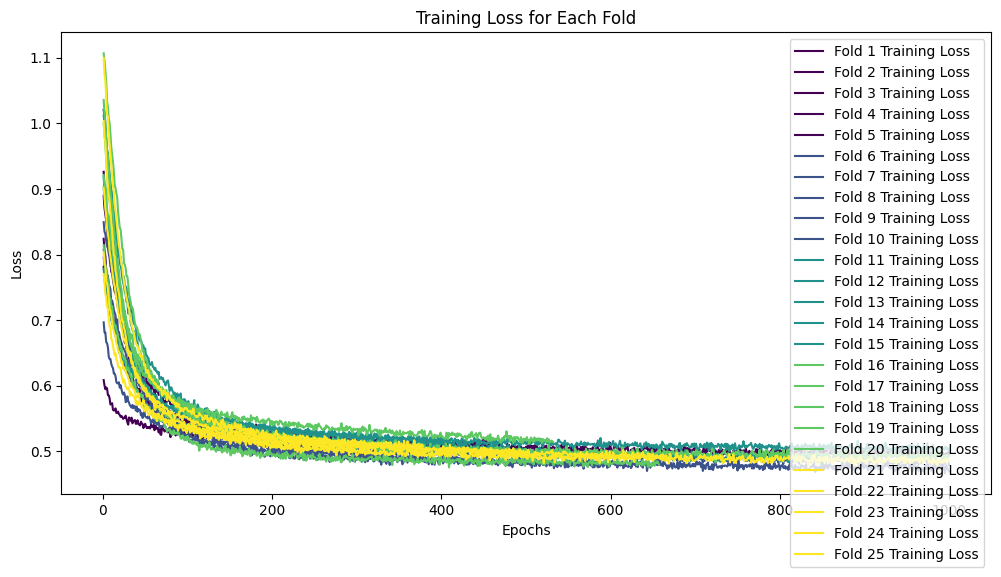

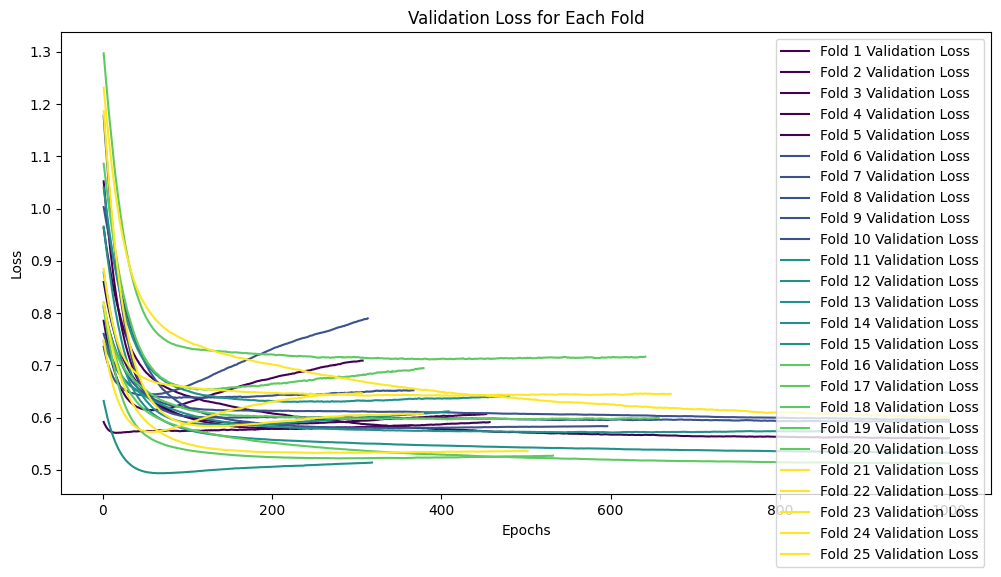

: 

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_only_val_loss.svg")
plt.show()